<a href="https://colab.research.google.com/github/AlanKev117/data-engineering-bootcamp/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project for Wizeline's Data Engineering Bootcamp
---
### By Alan Fuentes

In [ ]:
!pip install --upgrade statsmodels # upgrades statsmodels

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

## A quick review through the sample dataset
I decided to take a look at the sample dataset to get familiar with the column names and also to choose the ones that might be useful in order to find some interesting information

In [ ]:
sample = pd.read_csv("sample.csv") # place sample file in same location as notebook or edit with local path (optional)
sample.tail(5)

I choose olny those columns that are relevant to solve the first three questions:

In [ ]:
columns_to_use = ["producto", "presentacion", "cadenaComercial", "estado", "precio", "fechaRegistro"]

I created a symbolic link to the large file into my Drive account so I could read it faster in Google Colab.

In [ ]:
# This cell will mount your Drive unit to the Colab file system.
# Skip if running locally
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading the large file

In [ ]:
# Path to the file in my Drive account, replace with yours (might be a local path).
HUGE_FILE_PATH = "/content/drive/MyDrive/profeco.zip"

The chunk size is large enough to read the whole dataset quite fast and still not run out of memory.

In [ ]:
# Replace with 1e5 or below if running locally and RAM memory is less or equal to 8GB (it will take longer)
CHUNK_SIZE = 1e7

We set up the reading process

In [ ]:
# Set two column types as string. It will use more memory but will read faster since no parsing is done.
data = pd.read_csv(HUGE_FILE_PATH, chunksize=CHUNK_SIZE, usecols=columns_to_use, dtype={"fechaRegistro": "str", "precio": "str"})

Since the dataset is a large file, it will be read chunk by chunk in order to reduce memory usage while fetching data.

In [ ]:
# It takes about 4 mins. to load the required data as long as it is run in Colab with CHUNK_SIZE = 1e7
dataset = data.get_chunk()
for chunk in data:
    dataset = dataset.append(chunk, ignore_index=True)

## Parsing data

Parsing registry dates.


In [ ]:
registry_date = pd.to_datetime(dataset["fechaRegistro"], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
dataset["fechaRegistro"] = registry_date

 Check completeness rate.

In [ ]:
missing_dates = sum(registry_date.isna())
all_dates = registry_date.size
print(f"There are {missing_dates} missing dates. There is a {(all_dates-missing_dates)/all_dates*100}% of valid dates")

There are 20 missing dates. There is a 99.99996801571835% of valid dates


Parse prices from string to float

In [ ]:
price = pd.to_numeric(dataset["precio"], errors="coerce")
dataset["precio"] = price

 Check completeness rate.

In [ ]:
missing_prices = sum(price.isna())
all_prices = price.size
print(f"There are {missing_prices} missing prices. There is a {(all_prices-missing_prices)/all_prices*100}% of valid prices")

There are 20 missing prices. There is a 99.99996801571835% of valid prices


## A1: How many commercial chains are monitored?



First, data is grouped by commercial chain and then counted in an arbitrary column

In [ ]:
commercial_chain_count = dataset.groupby(["cadenaComercial"])["producto"].count()
commercial_chain_count.drop(index=["cadenaComercial"], inplace=True, errors="ignore") # drops the record that contains the header
commercial_chain_count

cadenaComercial
7 ELEVEN                           55946
ABARROTERA DE BAJA CALIFORNIA       2123
ABARROTERA DE TLAXCALA             10941
ABARROTERA GUADALUPANA (FRUTAS)    50422
ABARROTERA MONTERREY               26249
                                   ...  
ZAPATERIA TLAXCALA                    32
ZAPATERIA ZLOP                       115
ZAPATERIAS 3 HERMANOS                366
ZAPOPAN ESCOLAR                    14413
ZARAGOZA MUEBLES                     667
Name: producto, Length: 704, dtype: int64

The index of the resulting series is the actual list of commercial chains. Its size is the response.


In [ ]:
commercial_chains = commercial_chain_count.index.size
print(f"There are {commercial_chains} commercial chains whose products are being monitored")

There are 704 commercial chains whose products are being monitored


In [ ]:
commercial_chain_count.to_csv("commercial_chains.csv") # Save series to file for further manual check (optional).

## A2: Top 10 monitored products by State

First, we group the data by the columns state, product and presentation. Then we count monitored items in an aggregate column.

In [ ]:
state_product_count = dataset.groupby(["estado", "producto", "presentacion"])["producto"].count()
state_product_count.drop(labels="estado", level=0, inplace=True, errors="ignore") # drops the generated record that contains the header
state_product_count

estado          producto       presentacion                                 
AGUASCALIENTES  A.S.COR        FRASCO GOTERO 24 ML. 1.000 G., SOLUCION GOTAS    175
                ABILIFY        CAJA CON 10 TABLETAS DE 15 MG.                    94
                ACARBOSA       CAJA CON 30 TABLETAS DE 50 MG.                   145
                ACEITE         BOTELLA 1 LT. CANOLA                             642
                               BOTELLA 1 LT. MAIZ                               150
                                                                               ... 
ZACATECAS       ZWAN. PREMIUM  PAQUETE 500 GR. SALCHICHA. DE PAVO               656
                               PAQUETE 520 GR. SALCHICHA. DE PAVO               145
                ZYLOPRIM       CAJA CON 30 TABLETAS DE 300 MG.                  371
                ZYPREXA        CAJA CON 14 TABLETAS DE 10 MG.                   216
                               CAJA CON 14 TABLETAS DE 5 MG.                    316

If decide to use all of the **three columns**, group again only by state and fetch top ten items.




In [ ]:
top_10_by_state_with_p = state_product_count.groupby("estado", group_keys=False).nlargest(10)
top_10_by_state_with_p

estado          producto                 presentacion                       
AGUASCALIENTES  TINTE PARA EL CABELLO    CAJA                                   4170
                DETERGENTE P/ROPA        BOLSA 1 KG. POLVO                      3558
                HORTALIZAS CONGELADAS    BOLSA 500 GR.                          3459
                AGUA SIN GAS             BOTELLA 1.5 LT.                        3172
                YOGHURT                  BOTE 1 KG. FRESA                       2663
                                                                                ... 
ZACATECAS       JABON DE TOCADOR         BARRA 180 GR.                          5055
                YOGHURT                  BOTE 1 KG. FRESA                       4425
                LECHE ULTRAPASTEURIZADA  PARCIALMENTE DESCREMADA. CAJA 1 LT.    4147
                LECHE PASTEURIZADA       CAJA 1 LT.                             4066
                LECHE ULTRAPASTEURIZADA  CAJA 1 LT. ENTERA               

In this approach, considering the presentation column, ultrapasteurized milk has two variants: **partialy descremed** and **whole**. Therefore, they are considered to be two distinct products (see output above for Zacatecas). 

In [ ]:
top_10_by_state_with_p.to_csv("top_10_by_state_with_presentation.csv") # Save to file (optional)

If we decide to **skip the presentation column**, we sum all of the rows that match state and product. Then group by state and get top 10.




In [ ]:
top_10_by_state_without_p = state_product_count.groupby(["estado", "producto"], group_keys=False).sum()
top_10_by_state_without_p = top_10_by_state_without_p.groupby("estado", group_keys=False).nlargest(10)
top_10_by_state_without_p

estado          producto               
AGUASCALIENTES  FUD                        12005
                DETERGENTE P/ROPA          10188
                LECHE ULTRAPASTEURIZADA     9824
                SHAMPOO                     9654
                REFRESCO                    9481
                                           ...  
ZACATECAS       FUD                        15541
                SHAMPOO                    15012
                CHILES EN LATA             14866
                COMPONENTES DE AUDIO       14799
                REFRESCO                   13925
Name: producto, Length: 320, dtype: int64

In this approach, ultrapasteurized milk should be just one product but this time its amount will not be enough to make it a top 10 product for Zacatecas.

In [ ]:
top_10_by_state_without_p.to_csv("top_10_by_state_without_presentation.csv") # Save to file (optional)

## A3: Commercial chain with the most monitored products
It reduces to fetching the larges value in the `commercial_chain` series, since it already has the count of monitored products by chain.

In [ ]:
print("Commercial chain with the most monitored products:")
print(commercial_chain_count.nlargest(1))

Commercial chain with the most monitored products:
cadenaComercial
WAL-MART    8643133
Name: producto, dtype: int64


## A4: An interesting fact: how price fluctuates over time for some products.
It might be interesting to analyze some of the common top products by state. We could check how their price varies through time.

Fisrt, let us take a look at the top monitored presentations for two products:

In [ ]:
product1 = "DETERGENTE P/ROPA"
product2 = "TINTE PARA EL CABELLO"

products_data = dataset[dataset["producto"].isin((product1, product2))][["producto", "precio", "presentacion", "fechaRegistro"]]

detergent_data = products_data[products_data["producto"] == product1]
dye_data = products_data[products_data["producto"] == product2]

print(detergent_data.groupby("presentacion")["presentacion"].count().nlargest(1))
print(dye_data.groupby("presentacion")["presentacion"].count().nlargest(1))

presentacion
BOLSA 1 KG. POLVO    312344
Name: presentacion, dtype: int64
presentacion
CAJA    335932
Name: presentacion, dtype: int64


Next, we get the time series for the median price and the production amount by grouping all data by registry date.

As an aggregate function, **median** is chosen instead of **mean**, since it does not take into consideration outliying values (too large or too short).

In [ ]:
detergent_ts = detergent_data[detergent_data["presentacion"] == "BOLSA 1 KG. POLVO"].groupby("fechaRegistro").agg(
    price=pd.NamedAgg(column='precio', aggfunc=np.median), # median is a better statistic value for this scenario
)
dye_ts = dye_data[dye_data["presentacion"] == "CAJA"].groupby("fechaRegistro").agg(
    price=pd.NamedAgg(column='precio', aggfunc=np.median), # median is a better statistic value for this scenario
)

This is how the price of the detergent changes through time:

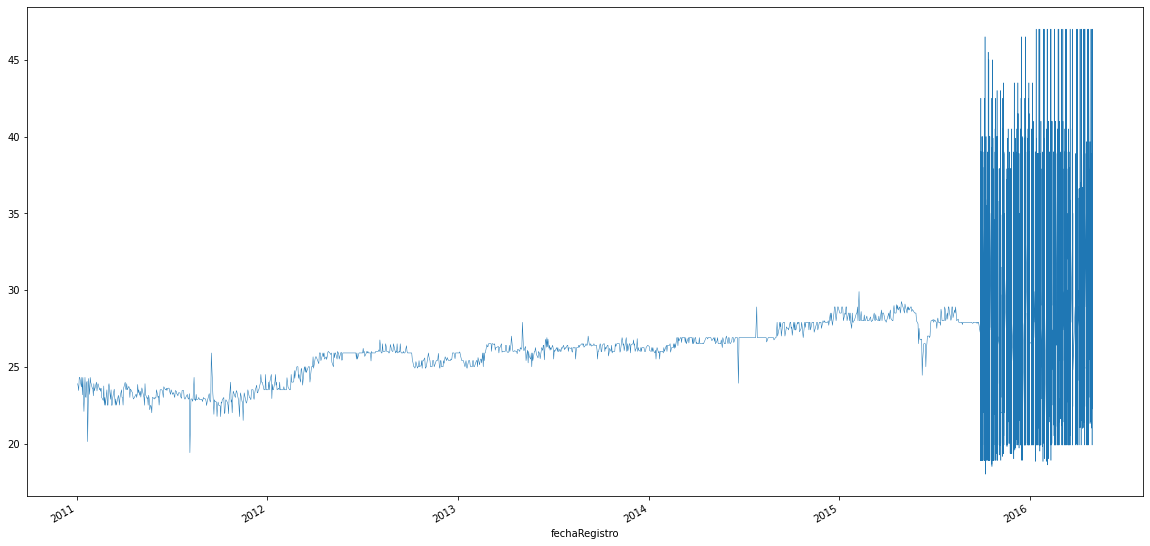

In [ ]:
detergent_ts["price"].plot(linewidth=0.5,figsize=(20, 10))

We can decompose the series 

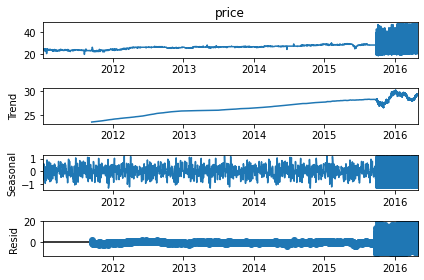

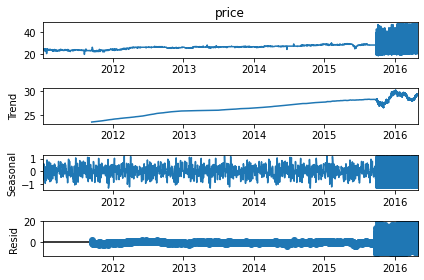

In [ ]:
sd1 = seasonal_decompose(detergent_ts["price"], model="additive",period=365)
sd1.plot()

We can see that there is no seasonal pattern. Nonetheless, there is an **increasing trend** in price.

We can do the same for hair dye.

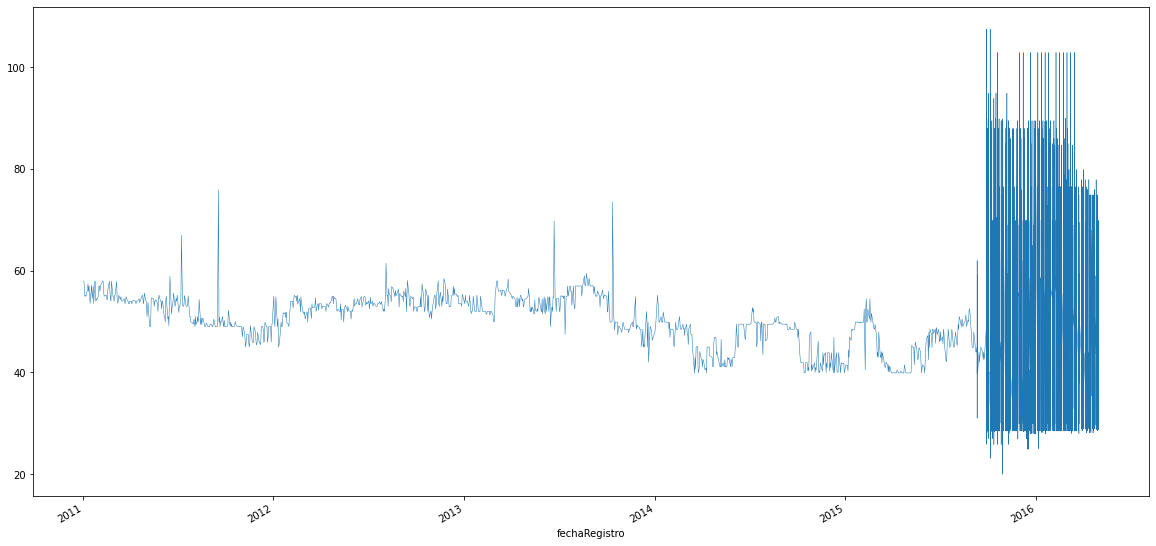

In [ ]:
dye_ts["price"].plot(linewidth=0.5,figsize=(20, 10))

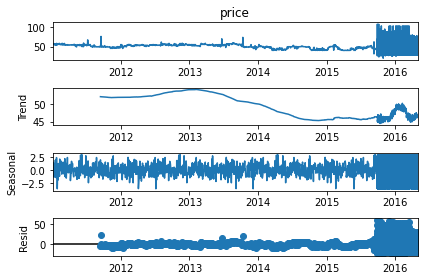

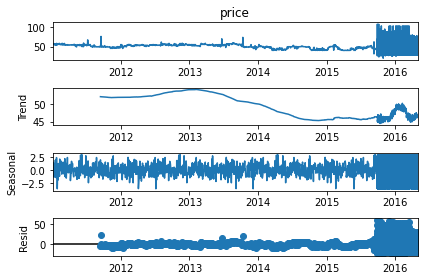

In [ ]:
seasonal_decompose(dye_ts["price"], model="additive", period=365).plot()

As we can se, there seems to be no seasonal patterns either. However **price has been dropping since 2013**.